In [2]:
import medmnist

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO

/Users/valentinbiller/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/valentinbiller/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/valentinbiller/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <91E09CD3-B54F-3961-87C1-B0D20E3D1C3F> /Users/valentinbiller/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
def train(model, loader, optimizer, convert_to_binary, epochs, device):
    criterion_ce = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        for inputs, targets in tqdm(loader):
            # forward + backward + optimize
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            targets = targets.squeeze().float()
            # TODO: Convert to binary classification
            if convert_to_binary:
                outputs = torch.sigmoid(outputs)
                outputs = (outputs > 0.5).float()

                # Convert to binary tensor (1 if sum > 0, 0 otherwise)
                targets_binary = targets.squeeze().sum(dim=1)
                targets_binary = (targets_binary > 0).float().view(-1, 1)

                # Concatenate with the original tensor to get the final result
                targets = torch.cat([targets_binary, 1 - targets_binary], dim=1)
                targets = targets.requires_grad_()
                # Display the result
            loss = criterion_ce(outputs, targets)
            avg_loss += loss.item()

            loss.backward()
            optimizer.step()
        avg_loss /= len(loader)
        print('Epoch: {}\tLoss: {:.4f}'.format(epoch+1, avg_loss))
    return model

In [4]:
def test(model, data_loader, device, convert_to_binary):
    model.eval()
    y_true = torch.tensor([], device=device)
    y_score = torch.tensor([], device=device)

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            targets = targets.squeeze().long()
            # TODO: Convert to binary classification
            if convert_to_binary:
                outputs = torch.sigmoid(outputs)
                outputs = (outputs > 0.5).float()

                # Convert to binary tensor (1 if sum > 0, 0 otherwise)
                targets_binary = targets.squeeze().sum(dim=1)
                targets_binary = (targets_binary > 0).float().view(-1, 1)

                # Concatenate with the original tensor to get the final result
                targets = torch.cat([targets_binary, 1 - targets_binary], dim=1)
                targets = targets.requires_grad_()

            outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_preds = torch.max(y_score, dim=1)[1]

        # TODO: Accuracy
        # Calculate accuracy
        correct = (y_preds == y_true[:, 1].long()).sum().item()
        total = y_true.size(0)
        acc = correct / total

        print('Accuracy: %.3f' % (acc))

# Chest

In [5]:
data_flag_chest = 'chestmnist'
download = True

lr = 0.001

info_chest = INFO[data_flag_chest]
task_chest = info_chest['task']
n_channels_chest = info_chest['n_channels']
#n_classes_chest = len(info_chest['label'])
n_classes_chest = 2
DataClass_chest = getattr(medmnist, info_chest['python_class'], "binary-class")

In [6]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the chest data
train_dataset_chest = DataClass_chest(split='train', transform=data_transform, download=download)
test_dataset_chest = DataClass_chest(split='test', transform=data_transform, download=download)

train_dataset_chest_full = DataClass_chest(split='train', transform=data_transform, download=download)
train_loader_chest_full = data.DataLoader(dataset=train_dataset_chest_full, batch_size=256, shuffle=True)

# Lets pretend we only have labels for 300 training examples
train_dataset_chest.imgs = train_dataset_chest.imgs[:300]
train_dataset_chest.labels = train_dataset_chest.labels[:300]

# encapsulate data into dataloader form
train_loader_chest = data.DataLoader(dataset=train_dataset_chest, batch_size=64, shuffle=True)
test_loader_chest = data.DataLoader(dataset=test_dataset_chest, batch_size=64, shuffle=False)

Using downloaded and verified file: /Users/valentinbiller/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/valentinbiller/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/valentinbiller/.medmnist/chestmnist.npz


In [7]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
            
        self.linear1 = nn.Sequential(
            nn.Linear(256, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
        )
        
        self.linear2 = nn.Sequential(
            nn.Linear(2048, 128),
        )
        
        self.classification = nn.Sequential(
            nn.Linear(128, num_classes)
        )
        
        self.extract_embeddings = False

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.view(x.size(0), -1)
        if self.extract_embeddings: 
            return x 
        
        x = self.linear1(x)
        x = self.linear2(x)

        x = self.classification(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_chest = Net(in_channels=n_channels_chest, num_classes=2).to(device)

optimizer_chest = optim.SGD(model_chest.parameters(), lr=lr, momentum=0.9)

model_chest = train(model_chest, train_loader_chest, optimizer_chest, convert_to_binary=True, epochs=20, device=device)

100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]


Epoch: 1	Loss: 0.7281


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


Epoch: 2	Loss: 0.7442


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.31it/s]


Epoch: 3	Loss: 0.7244


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.49it/s]


Epoch: 4	Loss: 0.7303


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.45it/s]


Epoch: 5	Loss: 0.7262


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.55it/s]


Epoch: 6	Loss: 0.7350


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.42it/s]


Epoch: 7	Loss: 0.7244


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.54it/s]


Epoch: 8	Loss: 0.7466


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.39it/s]


Epoch: 9	Loss: 0.7210


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.45it/s]


Epoch: 10	Loss: 0.7153


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.55it/s]


Epoch: 11	Loss: 0.7202


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.02it/s]


Epoch: 12	Loss: 0.7336


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


Epoch: 13	Loss: 0.7267


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.47it/s]


Epoch: 14	Loss: 0.7355


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.45it/s]


Epoch: 15	Loss: 0.7186


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.44it/s]


Epoch: 16	Loss: 0.7190


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.42it/s]


Epoch: 17	Loss: 0.7233


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.43it/s]


Epoch: 18	Loss: 0.7422


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.47it/s]


Epoch: 19	Loss: 0.7448


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.51it/s]

Epoch: 20	Loss: 0.7160


In [46]:
# Assuming train_dataset_chest.labels is a numpy array
labels = train_dataset_chest.labels

# Convert numpy array to PyTorch tensor
labels_tensor = torch.from_numpy(labels).unsqueeze(1)  # Add an extra dimension

# Convert to binary tensor (1 if at least one 1 is present, 0 otherwise)
binary_labels = (labels_tensor.sum(dim=1) > 0).float()

# Calculate the positive rate
positive_rate = binary_labels.mean().item()

# Print the result
print("Positive Rate:", positive_rate)

Positive Rate: 0.05166666582226753


In [47]:
# evaluation
print('==> Evaluating ...')
print('train')
test(model_chest, train_loader_chest, device, convert_to_binary=True)
print('test')
test(model_chest, test_loader_chest, device, convert_to_binary=True)

==> Evaluating ...
train
Accuracy: 0.530
test
Accuracy: 0.499


## Latent Space

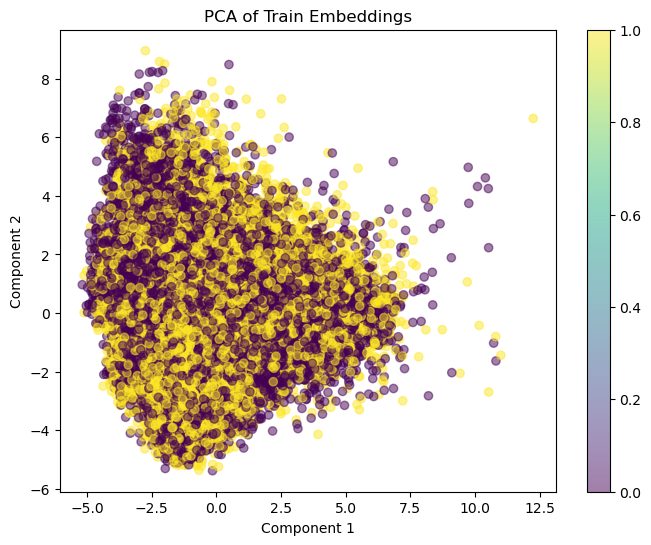

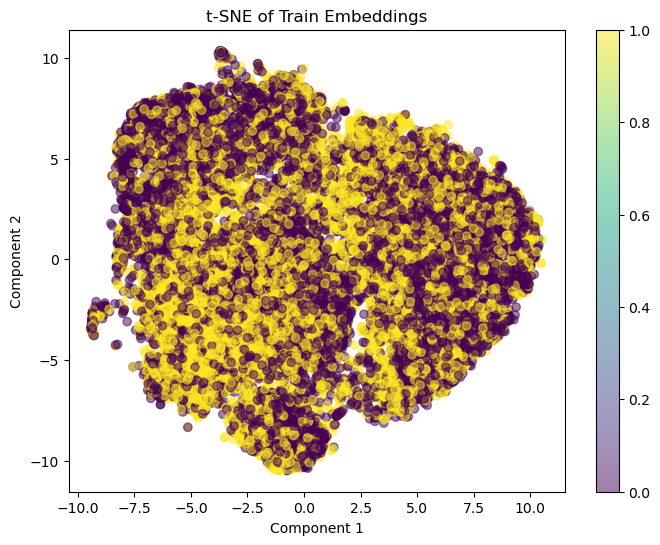

In [48]:
# EXAMINE LATENT SPACE

# Function to extract embeddings - TODO: Adjust the Net class to extract embeddings
def extract_embeddings(dataloader, model):
    embeddings = []
    labels = []

    with torch.no_grad():
        for x, target in dataloader:
            x = x.to(device)
            target = target.to(device)

            model.extract_embeddings = True
            output = model(x)
            model.extract_embeddings = False
            
            embeddings.append(output)
            labels.append(target)
    
    return torch.cat(embeddings), torch.cat(labels)

# Function to plot
def plot_embeddings(embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

test_embeddings, test_labels = extract_embeddings(test_loader_chest, model_chest)

# TODO: convert labels to binary
test_labels_binary = test_labels.squeeze().sum(dim=1)
test_labels_binary = (test_labels_binary > 0).float().view(-1, 1)
test_labels = torch.cat([test_labels_binary, 1 - test_labels_binary], dim=1)
test_labels = test_labels[:, 0]

import numpy as np
import matplotlib.pyplot as plt

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TODO: Apply PCA
def apply_pca(embeddings, num_components=2):
    pca = PCA(n_components=num_components)
    pca_result = pca.fit_transform(embeddings)
    return pca_result

pca_result = apply_pca(test_embeddings_flat)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Apply t-SNE
def apply_tsne(embeddings, num_components=2, perplexity=30, n_iter=300):
    tsne = TSNE(n_components=num_components, perplexity=perplexity, n_iter=n_iter)
    tsne_result = tsne.fit_transform(embeddings)
    return tsne_result
tsne_result = apply_tsne(test_embeddings_flat)

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


## Autoencoder

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
    
# ===== edited
import os
model_ae_path =  os.path.join('./model', "aeModel.pth")

# Set device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
# ===== edited
    
# TODO: Define an autoencoder model that is compatable with the previous model. Use dropout with probability p
class Autoencoder(nn.Module):
    def __init__(self, p):
        super(Autoencoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout2d(p),
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout2d(p),
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout2d(p),
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout2d(p),
        )
            
        self.linear1 = nn.Sequential(
            nn.Linear(256, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Dropout(p),
        )
        
        self.linear2 = nn.Sequential(
            nn.Linear(2048, 128),
        )
        
        self.linear_dec = nn.Sequential(
            nn.Linear(128, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Dropout(p),
            nn.Linear(2048, 256),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout2d(p),
            nn.ConvTranspose2d(256, 128, 4, 3, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout2d(p),
            nn.ConvTranspose2d(128, 64, 4, 3, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout2d(p),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
        )
        
        self.initialize()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.linear1(x)
        x = self.linear2(x)
        
        x = self.linear_dec(x)
        x = x.view(x.size(0), 256, 1, 1)
        x = self.decoder(x)
        return x
        
# Initialize the model, criterion, and optimizer
model_ae = Autoencoder(p=0.05).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.AdamW(model_ae.parameters(), lr=0.0001, weight_decay=0.01)

# Metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

In [9]:
# ===== edited
train_losses = []
train_psnrs = []
train_ssims = []
best_loss = 10
best_epoch = -1
patience = 20
# ===== edited

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model_ae.train()

    # ===== edited
    tqdm_train_loader = tqdm(train_loader_chest_full, desc=f'Epoch {epoch + 1}/{num_epochs}', dynamic_ncols=True)
    # ===== edited
    
    for x in tqdm_train_loader:
        inputs, _ = x
        inputs = inputs.to(device)
        
        # Forward pass
        outputs = model_ae(inputs)
        loss = criterion_ae(outputs, inputs)
        
        psnr_value = psnr_metric(outputs, inputs)
        ssim_value = ssim_metric(outputs, inputs)
            
        # Backward pass and optimization
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()
        
        # ===== edited
        tqdm_train_loader.set_description(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, PSNR: {psnr_value.item():.4f}, SSIM: {ssim_value.item():.4f}')

    tqdm_train_loader.close()   
        
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
        torch.save(model_ae.state_dict(), model_ae_path)
        print(f'Model saved!')
    if (epoch - best_epoch) > patience:
        break
        
    train_losses.append(loss.item())
    train_psnrs.append(psnr_value.item())
    train_ssims.append(ssim_value.item())
    # ===== edited
    
    # Print the metrics for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr_value.item():.4f}, SSIM: {ssim_value.item():.4f}')

    psnr_metric.reset()
    ssim_metric.reset()

# Test the autoencoder on the test set
model_ae.eval()
test_loss = 0.0
psnr_value_test = 0.0, 0.0
ssim_value_test = 0.0, 0.0
with torch.no_grad():
    for x in test_loader_chest:
        inputs, _ = x
        inputs = inputs.to(device)
        outputs = model_ae(inputs)

        loss = criterion_ae(outputs, inputs)
        psnr_value_test = psnr_metric(outputs, inputs)
        ssim_value_test = ssim_metric(outputs, inputs)

        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader_chest.dataset)
average_psnr_test = psnr_metric.compute()
average_ssim_test = ssim_metric.compute()

print(f'Average Test Loss: {average_test_loss:.4f}, Average PSNR: {average_psnr_test:.4f}, Average SSIM: {average_ssim_test:.4f}')

# ===== edited
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_psnrs, label='Train PSNR')
plt.title('Training PSNR')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_ssims, label='Train SSIM')
plt.title('Training SSIM')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()

plt.tight_layout()
plt.show()
# ===== edited

Epoch 1/1, Loss: 0.0668, PSNR: 17.5987, SSIM: 0.6966: 100%|█| 307/307 [01:26<00:


Model saved!
Epoch [1/1], Loss: 0.0668, PSNR: 17.5987, SSIM: 0.6966
Average Test Loss: 0.0007, Average PSNR: 19.5616, Average SSIM: 0.5745


NameError: name 'plt' is not defined

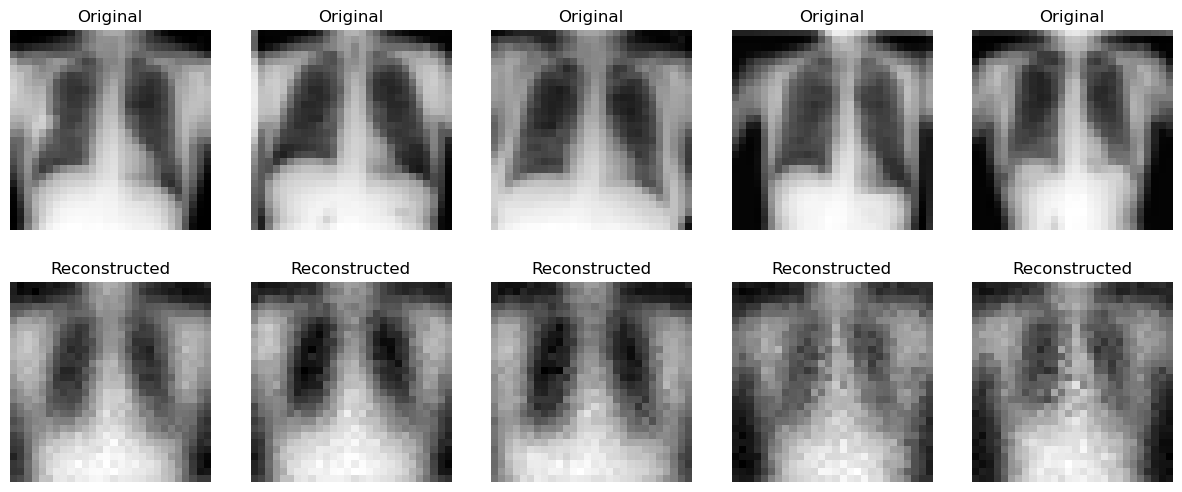

In [51]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# ===== edited
model_ae.load_state_dict(torch.load(model_ae_path))
# ===== edited

# TODO: Function to plot input and output images
def plot_images(model, test_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)

            # Forward pass through the autoencoder
            outputs = model(inputs)

            # Plot the original and reconstructed images
            plt.figure(figsize=(15, 6))
            for i in range(min(inputs.size(0), num_images)):
                # Original Image
                plt.subplot(2, num_images, i + 1)
                plt.imshow(inputs[i][0].cpu().numpy(), cmap='gray')
                plt.title('Original')
                plt.axis('off')

                # Reconstructed Image
                plt.subplot(2, num_images, i + num_images + 1)
                plt.imshow(outputs[i][0].cpu().numpy(), cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')

            plt.show()
            break  # Show only the first batch

# Use the function to plot images
plot_images(model_ae, test_loader_chest, device)

### Transfer Learning

In [12]:
# Create a new model with randomly initialized weights
model_transfer = Net(in_channels=n_channels_chest, num_classes=2).to(device)

# TODO: Transfer the weights into the new model
model_transfer_dict = model_transfer.state_dict()
model_ae_dict = torch.load(model_ae_path)
model_ae_dict_filtered = {k: v for k, v in model_ae_dict.items() if k in model_transfer_dict}

'''
from itertools import zip_longest
for key1, key2, key3 in zip_longest(model_transfer_dict.keys(), model_ae_dict.keys(), model_ae_dict_filtered.keys(), fillvalue=''):
    print(f'{key1: >35} --- {key2: >35} --- {key3: >35}')
'''

model_transfer_dict.update(model_ae_dict_filtered)
model_transfer.load_state_dict(model_transfer_dict)

# train
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=lr, momentum=0.9)

model_transfer = train(model_transfer, train_loader_chest, optimizer_transfer, convert_to_binary=True, epochs=20, device=device)

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 79.62it/s]


Epoch: 1	Loss: 0.7170


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 68.11it/s]


Epoch: 2	Loss: 0.7194


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 79.92it/s]


Epoch: 3	Loss: 0.7089


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 67.87it/s]


Epoch: 4	Loss: 0.7219


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 76.72it/s]


Epoch: 5	Loss: 0.7300


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 69.94it/s]


Epoch: 6	Loss: 0.7244


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 69.28it/s]


Epoch: 7	Loss: 0.7162


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 62.02it/s]


Epoch: 8	Loss: 0.7315


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 61.41it/s]


Epoch: 9	Loss: 0.7336


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 60.63it/s]


Epoch: 10	Loss: 0.7293


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 52.25it/s]


Epoch: 11	Loss: 0.7112


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 38.06it/s]


Epoch: 12	Loss: 0.7289


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 42.84it/s]


Epoch: 13	Loss: 0.7321


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 50.08it/s]


Epoch: 14	Loss: 0.7301


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 63.70it/s]


Epoch: 15	Loss: 0.7235


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 67.94it/s]


Epoch: 16	Loss: 0.7335


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 74.93it/s]


Epoch: 17	Loss: 0.7347


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 69.56it/s]


Epoch: 18	Loss: 0.7251


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 69.48it/s]


Epoch: 19	Loss: 0.7284


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 61.31it/s]

Epoch: 20	Loss: 0.7311


In [54]:
print('==> Evaluating ...')
test(model_transfer, train_loader_chest, device, convert_to_binary=True)
test(model_transfer, test_loader_chest, device, convert_to_binary=True)

==> Evaluating ...
Accuracy: 0.453
Accuracy: 0.471


# Pneumonia

In [ ]:
data_flag_pneumonia = 'pneumoniamnist'
info_pneumonia = INFO[data_flag_pneumonia]
task_pneumonia = info_pneumonia['task']
n_channels_pneumonia = info_pneumonia['n_channels']
n_classes_pneumonia = len(info_pneumonia['label'])
DataClass_pneumonia = getattr(medmnist, info_pneumonia['python_class'])

# load the pneumonia data
train_dataset_pneumonia = DataClass_pneumonia(split='train', transform=data_transform, download=download)
test_dataset_pneumonia = DataClass_pneumonia(split='test', transform=data_transform, download=download)

pil_dataset_pneumonia = DataClass_pneumonia(split='train', download=download)

# encapsulate data into dataloader form
train_loader_pneumonia = data.DataLoader(dataset=train_dataset_pneumonia, batch_size=64, shuffle=True)
test_loader_pneumonia = data.DataLoader(dataset=test_dataset_pneumonia, batch_size=64, shuffle=False)

In [ ]:
model_pneumonia = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

optimizer_pneumonia = optim.SGD(model_pneumonia.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train

model_pneumonia = train(model_pneumonia, train_loader_pneumonia, optimizer_pneumonia, convert_to_binary=False, epochs=10, device=device)

In [ ]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia, test_loader_pneumonia, device, convert_to_binary=False)

## Transfer learning

In [ ]:
# For transfer learning lets go back to the full dataset

model_chest_full = Net(in_channels=n_channels_chest, num_classes=2).to(device)
optimizer_chest_full = optim.SGD(model_chest_full.parameters(), lr=lr, momentum=0.9)

# train
model_chest_full = train(model_chest_full, train_loader_chest_full, optimizer_chest_full, convert_to_binary=True, epochs=20, device=device)

### Transfer learning - Frozen

In [ ]:
model_pneumonia_transfer_frozen = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights of the ENCODER from the chest model to the pneumonia model

# TODO: Freeze all layers except the FC

# Initialize the optimizer
optimizer_pneumonia_transfer_frozen = optim.SGD(model_pneumonia_transfer_frozen.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train
model_pneumonia_transfer_frozen = train(model_pneumonia_transfer_frozen, train_loader_pneumonia, optimizer_pneumonia_transfer_frozen, convert_to_binary=False, epochs=10, device=device)

In [ ]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_frozen, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_frozen, test_loader_pneumonia, device, convert_to_binary=False)

In [ ]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_frozen)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming train_embeddings and train_labels are obtained as shown in the previous step

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA

# TODO: Apply t-SNE

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


### Transfer learning - Trainable

In [ ]:
model_pneumonia_transfer_trainable = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights from the chest model to the pneumonia model

# Initialize the optimizer
optimizer_pneumonia_transfer_trainable = optim.SGD(model_pneumonia_transfer_trainable.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train
model_pneumonia_transfer_trainable = train(model_pneumonia_transfer_trainable, train_loader_pneumonia, optimizer_pneumonia_transfer_trainable, convert_to_binary=False, epochs=10, device=device)

In [ ]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_trainable, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_trainable, test_loader_pneumonia, device, convert_to_binary=False)

In [ ]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_trainable)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming train_embeddings and train_labels are obtained as shown in the previous step

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA

# TODO: Apply t-SNE

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


### BONUS: Transfer learning 